# OpenStreetMap Data Wrangling with MariaDB

### Objective

Choose any area of the world in https://www.openstreetmap.org and use data munging techniques, such as assessing the quality of the data for validity, accuracy, completeness, consistency and uniformity, to clean the OpenStreetMap data for a part of the world that you care about. Choose to learn SQL or MongoDB and apply your chosen schema to the project.

### Dataset

For this project I choose the Tampa area as that is my home and I'd like to understand more data about my home.   Using MapZen.com  I was able to find a page dedicated to extracts specifically for Tampa Bay area (https://mapzen.com/data/metro-extracts/metro/tampa_florida/)   and used the OSB XML data (https://s3.amazonaws.com/metro-extracts.mapzen.com/tampa_florida.osm.bz2) for my project.




### Tampa Bay

Tampa Bay is a general term used to refer to the city and towns surrounding Tampa to include Clearwater and St. Petersburg.   Tampa is that largest of only three cities in Hillsborough County, whereas Pinelas County houses two large cities, Clearwater and St. Petersburg, as well as many other small towns.

https://en.wikipedia.org/wiki/Tampa_Bay

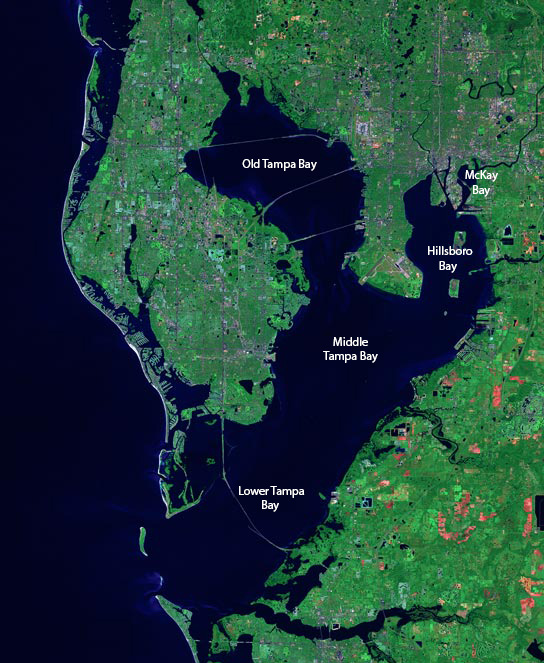

In [3]:
from IPython.display import Image
Image("https://upload.wikimedia.org/wikipedia/commons/5/5c/Tampa_florida_map.jpg", width ="400")

# Data Investigation

Data analysis will be accomplished with the help of MariaDB and Python.

Our data set contained these unique nodes (produced with counts.py).

```python
{'bounds': 1,
 'member': 33539,
 'nd': 5266087,
 'node': 4417067,
 'osm': 1,
 'relation': 1718,
 'tag': 2137661,
 'way': 676603}
 ```
 
 ## Issues
 
 During the initial exploration of the data I noticed issues with some of the data:
 
 #### Street and Directional Indicators Abbreviated (St instead of Street)
 
 Some street names were abbreviated, while others were spelled out.  In order to have consistent data I choose to spell out each instance of the abbreviations using the below corrections for street names and directional indicators.
 
 ##### Streets
 ```python
 STREET_FIXES = {
    "Ave": "Avenue",
    "Blvd": "Boulevard",
    "Dr": "Drive",
    "Pky": "Parkway",
    "Rd": "Road",
}
 ```
 
 ##### Directional
 ```python
 DIRECTION_FIXES = {
    "S": "South",
    "W": "West",
    "N": "North",
    "E": "East"
} 
 ```
 
 #### Directional indicators with the housenumber instead of the street address
 
 There were many instances where a house number would include the directional indicator (ie. 3200 West) in order to fix this I used the usaddress python library to help parse the addresses into usable pieces and reconsitute the address in the proper form.
 
 ```python
 addy = usaddress.tag(num)
if 'AddressNumber' in addy[0]:
    address['housenumber'] = addy[0]['AddressNumber']
if 'street' in address and 'StreetNamePreDirectional' in addy[0]:
    address['street'] = str.format('{} {}', addy[0]['StreetNamePreDirectional'], address['street'])

 ```
 #### House Numbers with the street address
 
 Using the same usaddress library, I was able to extract the house number from the street portion of the address and properly populate the house number into the data model.
 
 

## Data Overview

This section contains basic information regarding our dataset

* SAMPLE FILE SIZE: 11.98 MB
* PROD FILE SIZE: 957.64 MB

While loading the data into each table, our counts returned the following:
* 4417067 records written to Node table
* 162174 records written to Nodes Tags table
* 3709 records written to Nodes Adddress table
* 676603 records written to Ways table
* 1952072 records written to Ways Tags table
* 5266087 records written to Ways Nodes table

Our resultant database size:

```python
SELECT  
SUM(ROUND(((DATA_LENGTH + INDEX_LENGTH) / 1024 / 1024 ), 2)) AS "SIZE IN MB" 
FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = "udacity";

+------------+
| SIZE IN MB |
+------------+
| 1181.69    |
+------------+

```

## Interesting Data Points

##### Top Users

```python
MariaDB [udacity]> select user, count(2) 
from nodes 
group by user  
order by 2 desc 
limit 10;

+-----------------------+----------+
| user                  | count(2) |
+-----------------------+----------+
| Andrew Matheny_import |  1374679 |
| ninja_import          |   374399 |
| 25or6to4              |   274450 |
| woodpeck_fixbot       |   232867 |
| jharpster-import      |   212386 |
| coleman               |   202981 |
| TheDude05_import      |   180580 |
| grouper               |   176758 |
| Omnific               |   144005 |
| jharpster             |    95064 |
+-----------------------+----------+
```

##### Distinct Users
```python
MariaDB [udacity]> select 
COUNT(distinct user) as DISTINCT_USERS 
from nodes;

+----------------+
| DISTINCT_USERS |
+----------------+
|           1353 |
+----------------+
```

##### Top Amenities
We can see our top amenity type is restaurant follwed by place_of_worship.  

```python

MariaDB [udacity]> select value, count(2)  
from nodes_tags 
where `key`='amenity' 
group by value 
order by 2 desc 
limit 10;
+------------------+----------+
| value            | count(2) |
+------------------+----------+
| restaurant       |      840 |
| place_of_worship |      750 |
| school           |      497 |
| fast_food        |      378 |
| bicycle_parking  |      355 |
| bench            |      286 |
| fountain         |      222 |
| fuel             |      220 |
| bank             |      158 |
| toilets          |      146 |
+------------------+----------+
```

##### Top Restraunt Types
Looking at some of the values restraunts we see a decent mix of food options as I can attest to as a resident of the area.

```python
MariaDB [udacity]> select  `value`, count(2)  
from nodes_tags 
where node_id in (
    select node_id 
    from nodes_tags 
    where `key`='amenity' 
            and `value`='restaurant'
    ) 
    and `key`='cuisine' 
group by `value` 
order by 2 desc 
limit 10;

+----------+----------+
| value    | count(2) |
+----------+----------+
| american |       90 |
| pizza    |       70 |
| mexican  |       43 |
| italian  |       26 |
| chinese  |       25 |
| seafood  |       22 |
| greek    |       20 |
| sandwich |       18 |
| thai     |       18 |
| burger   |       16 |
+----------+----------+
```

##### Top Places of Worship
This query caught me a bit off guard as I thought there were more churches of other religions but my opinion is likely skewed by the size of those other churches that I see. 

```python
MariaDB [udacity]> select  `value`, count(2)  
from nodes_tags 
where node_id in (
    select node_id 
    from nodes_tags 
    where `key`='amenity' 
            and `value`='place_of_worship'
   ) 
   and `key`='religion' 
group by `value` 
order by 2 desc 
limit 10;
+------------------------+----------+
| value                  | count(2) |
+------------------------+----------+
| christian              |      703 |
| jewish                 |        4 |
| unitarian_universalist |        3 |
| bahai                  |        3 |
| buddhist               |        3 |
| scientologist          |        2 |
| muslim                 |        2 |
| spiritual_living       |        1 |
| eckankar               |        1 |
+------------------------+----------+
```

##### Top Coffee Shop
We can now say that Starbucks is more prevelant in the Tampa area than Dunkin' Donuts, despite my favoring the later.
```python
select `value`, count(2) 
from nodes_tags 
where `key`='name' 
and `value` in ('Starbucks','Dunkin\' Donuts') 
group by value;

+----------------+----------+
| value          | count(2) |
+----------------+----------+
| Dunkin' Donuts |       14 |
| Starbucks      |       48 |
+----------------+----------+
```

#### Top Cities 
We can see our top 10 cities (which have addresses) are quite unsurprising with Tampa leading the charge.

```python 
MariaDB [udacity]> select city, count(2) 
from nodes_address 
where city<>'' 
group by city 
order by 2 desc 
limit 10;

| city             | count(2) |
| Tampa            |      730 |
| Clearwater       |      375 |
| St. Petersburg   |      372 |
| Saint Petersburg |      255 |
| Pinellas Park    |      179 |
| Largo            |      160 |
| Sarasota         |       50 |
| Bradenton        |       48 |
| Ellenton         |       45 |
| Dunedin          |       44 |
```



## Improve the Data

I was not surprised to find the variability in the quality of the data as I know that it is mostly human entered. It does appear that some data has been appended from the USGS Geographic Names Information System (http://wiki.openstreetmap.org/wiki/USGS_GNIS) as the tags are all prepended with "gnis:". 

It would appear that some of these have been bulk appended based on the submission counts of various users.

```python
select user, count(2)  
from nodes_tags t 
inner join nodes n on t.node_id=n.id 
where `key` like 'gnis%' 
group by user 
order by 2 desc 
limit 10;
+-----------------+----------+
| user            | count(2) |
+-----------------+----------+
| iandees         |     2600 |
| Geogast         |     1972 |
| davidearl       |     1236 |
| amillar         |     1192 |
| coleman         |      472 |
| EdHillsman      |      338 |
| zacmccormick    |      304 |
| grouper         |      162 |
| woodpeck_repair |      154 |
| Jack the Ripper |      142 |
+-----------------+----------+
```


I believe would be interesting to append this data with other available government data sources to build a more complete public data set, but I would surmise that most government based data is also provided in some form by humans. Any data set that could be validated on entry against known good values would be good data to add which would limit the need to sanitize the data before using. 




## Conclusion

I was pleasantly surprised at the amount of data that is in the dataset for the Tampa Bay area. I also found a great deal of data that needed to corrected.   I found that processing data are raw strings was not possible to embedded UTF-8 encoded strings in the data, which had to be accounted for.



## References

* https://stackoverflow.com/questions/47871354/extract-street-address-without-numbered-street-names?noredirect=1#comment82709209_47871354
* https://mariadb.com/kb/en/library/documentation/
* https://docs.python.org/2/
